In [191]:
from utils import *
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from transformers import BertTokenizer, BertForTokenClassification, BertModel
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch import nn
model_name = "asafaya/bert-base-arabic"

In [185]:
def init_bert(name):   
    tokenizer = BertTokenizer.from_pretrained(name)
    model = BertModel.from_pretrained(name)
    return tokenizer, model

def init_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda:0")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    return device

def trigger_data_further_process(input):
    notes = input['notes']
    input_notes = []
    for i, note in enumerate(notes):
        if i == 0:
            if "T" in notes[i]:
                input_notes.append("B-T")
            else:
                input_notes.append("O")
        else:
            if "T" in notes[i]:
                if "T" not in notes[i-1]:
                    input_notes.append("B-T")
                else:
                    input_notes.append("I-T")
            else:
                input_notes.append("O")
    return input_notes

class pad_collate:
    def __init__(self,max_length):
        self.max_length = max_length
    def padding(self,batch):
        ids = [sample[0] for sample in batch]
        ids = pad_sequence(ids, batch_first=True)[:,:self.max_length]
        labels = [sample[-1] for sample in batch]
        labels = pad_sequence(labels, batch_first=True)[:,:self.max_length]
        masks = torch.zeros(size = ids.size())
        masks[ids > 0] = 1
        return ids, labels, masks
    def __call__(self,batch):
        return self.padding(batch)

In [158]:
class ace_dataset(Dataset):
    def __init__(self, datas, max_length, filter = False):
        if filter:
            datas = [x for x in datas if len(x['tokens']) <= max_length - 2]
        tokens = [x['tokens'] for x in datas]
        self.ids = [[2] + tokenizer.convert_tokens_to_ids(seq) + [3] for seq in tokens]
        labels = [trigger_data_further_process(x) for x in datas]
        self.map = {"O":0,"B-T":1,"I-T":2}
        self.labels = [[0]+[self.map[x] for x in y]+[0] for y in labels]
        self.len = len(self.ids)
        self.max_length = max_length
        self.tokens = tokens
        self.datas = datas
    def __getitem__(self,index):
        if type(index) == slice:
            id_torch = [torch.tensor(x) for x in self.ids[index]]
            label_torch  = [torch.tensor(x) for x in self.labels[index]]
            return pad_sequence(id_torch, batch_first = True)[:,:self.max_length],pad_sequence(label_torch, batch_first = True)[:,:self.max_length]
        else:
            id_torch = torch.tensor(self.ids[index])
            label_torch  = torch.tensor(self.labels[index])
            return id_torch[:self.max_length],label_torch[:self.max_length]
    def __len__(self):
        return self.len

def init_dataset(max_length,tokenizer):
    test_files, dev_files, train_files = get_data_paths("ace_2005/data/Arabic")
    train_processor = ara_ace_master(train_files, tokenizer)
    dev_processor = ara_ace_master(dev_files, tokenizer)
    test_processor = ara_ace_master(test_files, tokenizer)
    train_processor.extract_trigger_data()
    train_datas = [y for x in train_processor.trigger_datas for y in x]
    dev_processor.extract_trigger_data()
    dev_datas = [y for x in dev_processor.trigger_datas for y in x]
    test_processor.extract_trigger_data()
    test_datas = [y for x in test_processor.trigger_datas for y in x]
    train_dataset =  ace_dataset(train_datas,max_length,filter = True)
    dev_dataset = ace_dataset(dev_datas,max_length,filter = True)
    test_dataset  = ace_dataset(test_datas,max_length,filter = True)
    return train_dataset, dev_dataset, test_dataset

def init_dataloader(train_dataset, dev_dataset, test_dataset, batch_size, max_length):
    #func = lambda x:(pad_sequence([torch.tensor(seq) for seq in x[0]],batch_first=True)[:,:max_length],pad_sequence([torch.tensor(seq) for seq in x[1]],batch_first=True)[:,:max_length])
    train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True, collate_fn = pad_collate(max_length))
    dev_loader= DataLoader(dev_dataset,batch_size = 32, shuffle = True, collate_fn = pad_collate(max_length))
    test_loader = DataLoader(test_dataset,batch_size = 32, shuffle = True, collate_fn = pad_collate(max_length))
    return train_loader, dev_loader, test_loader

In [4]:
class focal_loss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=2 , size_average=True):
        super(focal_loss,self).__init__()
        self.size_average = size_average
        if isinstance(alpha,list):
            assert len(alpha)==num_classes   
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha<1  
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1-alpha)
        self.gamma = gamma
    def forward(self, preds, labels):
        # assert preds.dim()==2 and labels.dim()==1
        preds = preds.view(-1,preds.size(-1))
        self.alpha = self.alpha.to(preds.device)
        preds_softmax = preds
        #preds_softmax = F.softmax(preds, dim=1) 
        preds_logsoft = torch.log(preds_softmax)
        #focal_loss func, Loss = -α(1-yi)**γ *ce_loss(xi,yi)
        preds_softmax = preds_softmax.gather(1,labels.view(-1,1)) 
        preds_logsoft = preds_logsoft.gather(1,labels.view(-1,1))
        self.alpha = self.alpha.gather(0,labels.view(-1))
        # torch.pow((1-preds_softmax), self.gamma) 为focal loss中 (1-pt)**γ
        loss = -torch.mul(torch.pow((1-preds_softmax), self.gamma), preds_logsoft) 
        loss = torch.mul(self.alpha, loss.t())
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

class TokenClassification(nn.Module):
    def __init__(self,bert_model,num_label,device):
        super(TokenClassification, self).__init__()
        self.model = bert_model
        self.model = self.model.to(device)
        self.hidden_size = model.config.hidden_size
        self.num_label = num_label
        self.fc_logits = nn.Linear(self.hidden_size, self.num_label, bias = True)
        self.device = device
        self.loss_func = focal_loss(self.num_label)
    def forward(self,input_ids, attention_mask, labels):
        bert_output = self.model(input_ids = input_ids, attention_mask = attention_mask)
        hidden_state = bert_output.last_hidden_state
        trigger_logits = self.fc_logits(hidden_state)
        trigger_softmax = F.softmax(trigger_logits, dim = -1)
        loss = self.loss_func(trigger_softmax, labels)
        return trigger_softmax, loss
    def inferer(self,input):
        self.eval()
        input_tokens = tokenizer.tokenize(input)
        input_ids = tokenizer.encode(input,return_tensors="pt")
        input_ids = input_ids.to(self.device)
        #input_ids = input_ids.to(device)
        bert_output = self.model(input_ids = input_ids, attention_mask = None)
        #bert_output = trainer.model.model(input_ids = input_ids, attention_mask = None)
        hidden_state = bert_output.last_hidden_state
        trigger_logits = self.fc_logits(hidden_state)
        #trigger_logits = trainer.model.fc_logits(hidden_state)
        trigger_hat = trigger_logits.cpu().detach().argmax(dim = -1)
        trigger_hat = trigger_hat.squeeze()
        trigger_hat = trigger_hat[1:-1]
        return input_tokens,trigger_hat

class main_trainer:
    def __init__(self,model,lr,device,num_label):
        self.model = TokenClassification(model,num_label,device)
        self.lr = lr
        self.optim = Adam(self.model.parameters(),lr = self.lr)
        self.device = device
        self.model = self.model.to(self.device)
    def train(self,dataloader,epochs,eval_dataset):
        epoch_bar = tqdm(total = epochs, desc = "epoch")
        self.hist_train = []
        self.hist_eval = []
        for epoch in range(epochs):
            epoch_bar.set_postfix(epoch = epoch)
            train_bar = tqdm(total = len(dataloader),desc="train")
            epoch_pred = []
            epoch_true = []
            running_loss = 0
            for i, (ids, labels, masks) in enumerate(dataloader):
                self.model.train()
                self.optim.zero_grad()
                batch_size = ids.size()[0]
                ids = ids.to(self.device)
                labels = labels.to(self.device)
                masks = masks.to(self.device)
                trigger_softmax, loss = self.model(input_ids = ids, attention_mask = masks, labels = labels)
                #except:
                #    print(ids.shape,masks.shape,labels.shape)
                #    continue
                loss.backward()
                self.optim.step()
                y_pred = torch.argmax(trigger_softmax.cpu().detach(), dim = -1)[masks == 1]
                labels = labels.cpu().detach()
                y = labels[masks == 1]
                if len(set(y_pred.tolist())) == 1:
                    wrong = "error"
                else:
                    wrong = "none"
                epoch_pred += y_pred
                epoch_true += y
                epoch_acc = accuracy_score(epoch_true, epoch_pred)
                epoch_f1 = f1_score(epoch_true, epoch_pred,average='micro')
                train_bar.set_postfix(
                                    wrong = wrong,
                                    acc = epoch_acc,
                                    f1 = epoch_f1,
                                    loss = loss.item())
                running_loss += (loss.item() - running_loss)/(i+1)
                train_bar.update()
            train_bar.n = 0
            epoch_bar.update()
            self.hist_train.append((epoch_acc, epoch_f1, running_loss))
            eval_acc, eval_f1, eval_loss = self.eval(eval_dataset)
            self.hist_eval.append((eval_acc, eval_f1, eval_loss))
            epoch_bar.set_postfix(eval_acc = eval_acc, eval_f1 = eval_f1)
    def eval(self,dataset):
        self.model.eval()
        pred = []
        true = []
        running_loss = 0
        bar = tqdm(total = len(dataset), desc = "evaluating")
        for i, (ids, labels) in enumerate(dataset):
            ids = ids.to(self.device).unsqueeze(0)
            labels = labels.to(self.device).unsqueeze(0)
            trigger_softmax, loss = self.model(input_ids = ids, attention_mask= None,labels = labels)
            trigger_softmax = trigger_softmax.cpu().detach()
            y_pred = torch.argmax(trigger_softmax, dim = -1)
            y_pred = y_pred.squeeze()
            labels = labels.cpu().detach()
            labels = labels.squeeze()
            if len(set(y_pred.tolist())) == 1:
                error = "error"
            else:
                error = "none"
            pred += y_pred
            true += labels
            acc = accuracy_score(true, pred)
            f1 = f1_score(true, pred, average='micro')
            running_loss = (loss.item() - running_loss)/(i+1)
            bar.set_postfix(error = error, acc = acc, f1 = f1, loss = running_loss)
            bar.update()
        return acc, f1, running_loss

In [ ]:
def data_check(data):
    tokens = tokenizer.convert_ids_to_tokens(data[0])
    sent = " ".join(x for x in tokens)
    ids = data[1]
    trigger = []
    for i,(token,id) in enumerate(zip(tokens,ids)):
        if id == 1:
            head = tokens[i]
            trigger.append(head)
        if id == 2:
            trigger[-1] += " "+tokens[i]
    trigger_text = "|".join(x for x in trigger)
    print(f"sentence = {sent},triggers = {trigger_text}")

def show_length_distribution(dataset):
    lengths = []
    for data in dataset:
        length = len(data[0])
        lengths.append(length)
    pd.DataFrame(lengths).hist()

In [5]:
ace2005_path = "ace_2005/data/Arabic"
model_name = "asafaya/bert-base-arabic"
max_length = 100
batch_size = 32
lr = 0.0001
epoch = 30
tokenizer, model = init_bert(model_name)
device = init_device()
train_set, dev_set, test_set = init_dataset(max_length = max_length, tokenizer = tokenizer)
show_length_distribution(train_set)
train_loader, dev_loader, test_loader = init_dataloader(train_set, dev_set, test_set, batch_size = batch_size, max_length = max_length)

All TF 2.0 model weights were used when initializing BertForTokenClassification.

All the weights of BertForTokenClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForTokenClassification for predictions without further training.
  5%|▍         | 16/322 [00:00<00:01, 156.98it/s]

No GPU available, using the CPU instead.


100%|██████████| 41/41 [00:00<00:00, 159.52it/s]
322it [00:05, 64.37it/s, wrong_data=279]
40it [00:00, 80.93it/s, wrong_data=36]
41it [00:00, 62.94it/s, wrong_data=51]


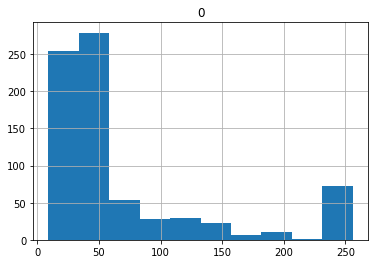

In [160]:
show_length_distribution(train_set)

In [192]:
tokenizer.encode("قال سعيد")

[2, 1909, 3649, 3]

In [ ]:
extracter = TokenClassification(model,3,device)

In [176]:
settings = {"model":model,"lr":lr,"device":device,"num_label":3}
#model,lr,device,num_label
trainer = main_trainer(**settings)
trainer.train(train_loader,20,dev_set)

sentence = [CLS] وفي قطاع غزة ، تعرضت عربة عسكرية لاطلاق نار من دون وقوع ضحايا بالقرب من مستوطن ##ة نت ##سار ##يم ، بحسب المصدر نفسه . [SEP],triggers = لاطلاق


In [ ]:
trainer.model.inferer(input)

In [ ]:
input = "تواصل حركة طالبان الزحف نحو العاصمة كابل، السبت، مع سقوط الولايات الأفغانية واحدة تلو الأخرى، وبعضها دون قتال، حيث باتت الحركة تسيطر على 14 من عواصم الأقاليم الأفغانية البالغ عددها 34 منذ السادس من أغسطس."
trainer.model.inferer(input,tokenizer)